In [ ]:
%matplotlib notebook

# Iris/dask dataset loading investigation

## Introduction

This demos using dask functionality beyond the `array` module to help with Iris processing. Specifically, in this notebook we will demo alternative approaches for loading numerous and/or large datasets into Iris.

Three approaches will be compared:

* The standard Iris load
* ~~Wrapping Iris load calls in a **dask bag** generated from a sequence (this is slow so will not be investigated further)~~
* Wrapping Iris load calls in a **dask bag** generated from a **delayed** call

These options will be compared with two simple metrics:

- Ease of use
- Runtime

## Setup

Below are the functions used to load the dataset. There is one function for each of the standard Iris load and the bag generated from a sequence. The bag generated from a delayed call requires two functions; one which is delayed, one to call the delayed function.

### Imports

In [2]:
import os
import time

import dask
import dask.bag as db
import dask.delayed as delayed
import iris
import matplotlib.pyplot as plt

### Dask processing options

Define options on how dask is to process computation of graphs. Choose one of these!

### Timer function

A simple function that records the runtime of a supplied function. This will be useful for capturing results; otherwise within this notebook we can just make use of the `%timeit` magic. 

In [3]:
def timer(func, *funcargs):
    t0 = time.time()
    func(*funcargs)
    t1 = time.time()
    return t1 - t0

### Possible load runner functions

In [4]:
@delayed
def loader(fn):
    return iris.load(os.path.join(fn))

def direct_load(fp, pattern):
    """Load datasets at the filepath `fp` using Iris."""
    iris.load(os.path.join(fp, pattern))

def delay_wrapper(fp, pattern):
    dlyd = delayed(iris.load)(os.path.join(fp, pattern))
    cs = db.from_delayed(dlyd)
    iris.cube.CubeList(cs.compute())

def delay_wrapper_v2(fp, seq):
    dlyds = [delayed(iris.load)(os.path.join(fp, pattern)) for pattern in seq]
    cs = db.from_delayed(dlyds)
    iris.cube.CubeList(cs.compute())

def delay_wrapper_v3(fp, seq):
    cs = db.from_delayed(map(loader, [os.path.join(fp, fn) for fn in seq]))
    iris.cube.CubeList(cs.compute())

### Graphs

Draw the graph of each of the distributed processing options. We can use the graph to determine which of the runner functions will parallelise best, and only use that function going forward.

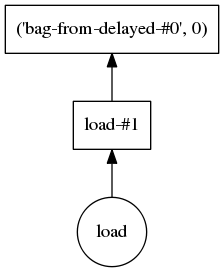

In [6]:
# Test `delay_wrapper()`.

%matplotlib inline

dlyd = delayed(iris.load)(os.path.join(fp, '*.pp'))
cs = db.from_delayed(dlyd)
cs.visualize()

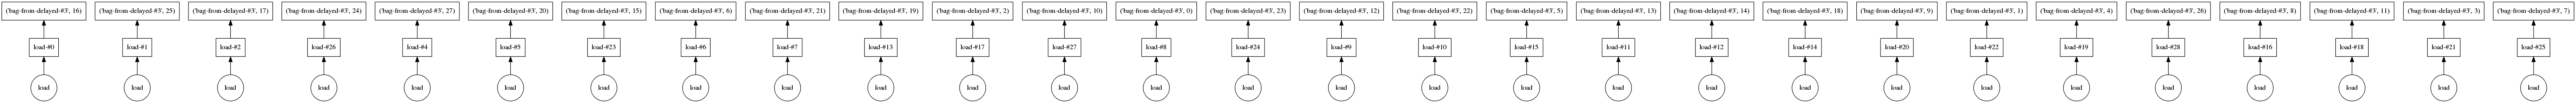

In [7]:
# Test `delay_wrapper_v2()`.

%matplotlib inline

dlyds = [delayed(iris.load)(os.path.join(fp, pattern)) for pattern in seq]
cs = db.from_delayed(dlyds)
cs.visualize()

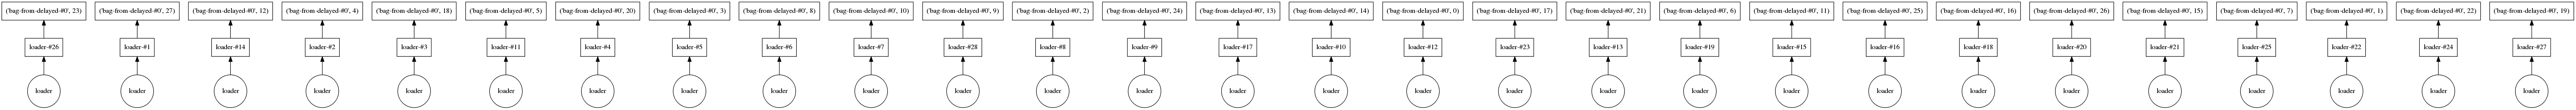

In [8]:
# Test `delay_wrapper_v3()`.

%matplotlib inline

cs = db.from_delayed(map(loader, [os.path.join(fp, fn) for fn in seq]))
cs.visualize()

## Test

Run the best loader function in the following processing environments:

* on SPICE with no parallelisation,
* on SPICE using a thread pool of 8 workers, and
* using a distributed scheduler with 8 workers

using **sample PP data** at `/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z`.

In [9]:
fp = '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z'
fn = '*.pp'
seq = os.listdir(fp)

### No parallelisation

In [9]:
direct_vals = timer(direct_load, fp, fn)
print direct_vals

5.38039398193


In [12]:
# Retain value over notebook restart.
direct_vals = 5.38039398193

### ThreadPool of 8 workers

In [10]:
from multiprocessing.pool import ThreadPool

dask.set_options(pool=ThreadPool(8), get=dask.multiprocessing.get)

In [11]:
print dask.context._globals

defaultdict(<function <lambda> at 0x7f7e31964a28>, {'callbacks': set([]), 'pool': <multiprocessing.pool.ThreadPool object at 0x7f7e2b312a10>, 'get': <function get at 0x7f7e31764f50>})


In [14]:
threadpool_vals = timer(delay_wrapper_v2, fp, seq)
print threadpool_vals

220.11837697


In [11]:
# Retain value over notebook restart.
threadpool_vals = 220.11837697

### Distributed client with 8 workers

In [6]:
from distributed import Client

host_subnet = 60
s = '10.154.1.{}:8776'.format(host_subnet)

client = Client(s)

In [7]:
print dask.context._globals

defaultdict(<function <lambda> at 0x7f45c9a12758>, {'callbacks': set([]), 'shuffle': 'tasks', 'get': <bound method Client.get of <Client: scheduler="10.154.1.60:8776" processes=8 cores=8>>})


In [10]:
dist_vals = 100.

In [10]:
dist_vals = timer(delay_wrapper_v3, fp, seq)
print dist_vals

54.6181571484


### Plot results

In [ ]:
fig = plt.figure(figsize=(9, 6))
plt.bar([1, 2, 3], [direct_vals, threadpool_vals, dist_vals],
        tick_label=['direct', 'ThreadPool', 'distributed'], align='center')
plt.show()